In [1]:
# Definimos la ruta de la carpeta que contiene las imágenes Landsat
folder_path = "/content/drive/MyDrive/Lansat/texas"

# **Inundación - Texas**

### 1. Calcular una estimación del área de la inundación de Texas (en km2)

In [2]:
# Importamos las librerías necesarias para llevar a acabo este trabajo
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [11]:
# Leemos las bandas de infrarojo cercanos (NNIR) y las bandas (SWIR) de agosto y septiembre
agosto_nir = cv2.imread("/content/drive/MyDrive/Lansat/texas/agosto_banda4.tif", cv2.IMREAD_GRAYSCALE)
agosto_swir = cv2.imread("/content/drive/MyDrive/Lansat/texas/agosto_banda5.tif", cv2.IMREAD_GRAYSCALE)

septiembre_nir = cv2.imread("/content/drive/MyDrive/Lansat/texas/septiembre_banda4.tif", cv2.IMREAD_GRAYSCALE)
septiembre_swir = cv2.imread("/content/drive/MyDrive/Lansat/texas/septiembre_banda5.tif", cv2.IMREAD_GRAYSCALE)

In [12]:
# Convertimos la imagen a float
agosto_nir_float = agosto_nir.astype(float) / 255.0
agosto_swir_float = agosto_swir.astype(float) / 255.0

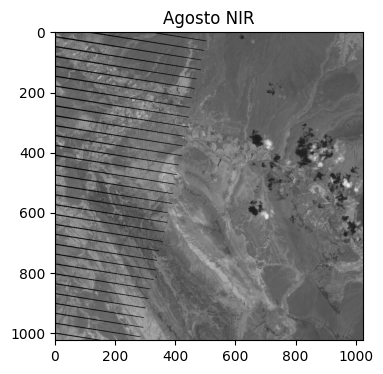

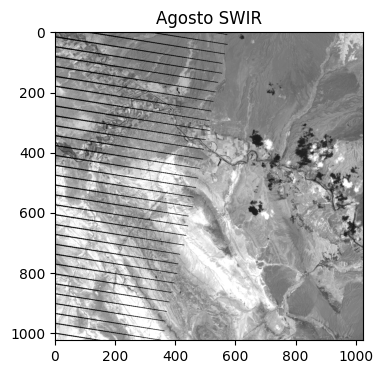

In [18]:
# Mostrar la imagen NIR
plt.figure(figsize=(4, 4))
plt.imshow(agosto_nir_float, cmap='gray')
plt.title('Agosto NIR')
plt.axis('on')
plt.show()

# Mostrar la imagen SWIR
plt.figure(figsize=(4, 4))
plt.imshow(agosto_swir_float, cmap='gray')
plt.title('Agosto SWIR')
plt.axis('on')
plt.show()


#### 1.1 alineamos las bandas correctamente

Realizamos la alineación de las imágenes utilizando la función cv2.registerTranslation. Suponiendo que las imágenes de agosto son las imágenes de referencia Alineamos las bandas de septiembre con las bandas de agosto.

In [53]:
# Obtener la matriz de traslación
tx, ty = 10, 20
M = np.float32([[1, 0, tx], [0, 1, ty]])

# Aplicar la traducción a las imágenes
agosto_nir_aligned = cv2.warpAffine(agosto_nir, M, (agosto_nir.shape[1], agosto_nir.shape[0]))
agosto_swir_aligned = cv2.warpAffine(agosto_swir, M, (agosto_swir.shape[1], agosto_swir.shape[0]))
septiembre_niir_aligned = cv2.warpAffine(septiembre_nir, M, (septiembre_nir.shape[1], septiembre_nir.shape[0]))
septiembre_swir_aligned = cv2.warpAffine(septiembre_swir, M, (septiembre_swir.shape[1], septiembre_swir.shape[0]))

### 1.2 Eliminamos las franjas negras generadas por la avería en los sensores del satélite.

In [21]:
 # Máscara para las franjas negras
mascara_negra = np.zeros_like(agosto_nir)
mascara_negra[agosto_nir == 0] = 255

# Aplicar la máscara en las imágenes antes y después de la inundación
agosto_nir = cv2.bitwise_and(agosto_nir, 255 - mascara_negra)
agosto_swir = cv2.bitwise_and(agosto_swir, 255 - mascara_negra)
septiembre_nir = cv2.bitwise_and(septiembre_nir, 255 - mascara_negra)
septiembre_swir = cv2.bitwise_and(septiembre_swir, 255 - mascara_negra)

### 1.3 Calculamos NDWI antes y despues de la inundación para obtener la imagen con el cambio, la cual permitirá obtener el área aproximada de inundación.

<ipython-input-23-dfe95f048a50>:8: RuntimeWarning: invalid value encountered in true_divide
  ndwi_agosto = (agosto_nir - agosto_swir) / (agosto_nir + agosto_swir)
<ipython-input-23-dfe95f048a50>:9: RuntimeWarning: invalid value encountered in true_divide
  ndwi_septiembre = (septiembre_nir - septiembre_swir) / (septiembre_nir + septiembre_swir)


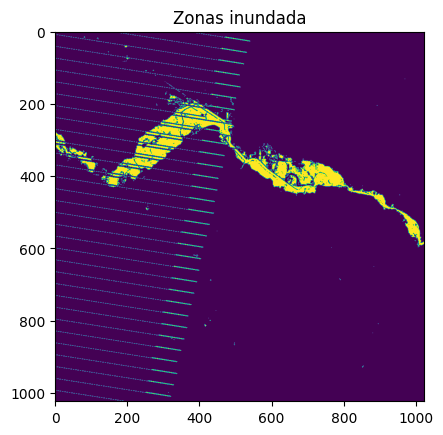

In [23]:
# Convertir las imágenes tipo float32
agosto_nir = agosto_nir.astype(np.float32)
agosto_swir = agosto_swir.astype(np.float32)
septiembre_nir = septiembre_nir.astype(np.float32)
septiembre_swir = septiembre_swir.astype(np.float32)

# Calculo NDWI antes y después de la inundación
ndwi_agosto = (agosto_nir - agosto_swir) / (agosto_nir + agosto_swir)
ndwi_septiembre = (septiembre_nir - septiembre_swir) / (septiembre_nir + septiembre_swir)

# Restar el NDWI después del NDWI antes para obtener una imagen de cambio
imagen_de_cambio = ndwi_septiembre - ndwi_agosto

# Aplicar un umbral para identificar las áreas de inundación
umbral = 0.4
zonas_inundadas = np.where(imagen_de_cambio > umbral, 255, 0).astype(np.uint8)

# Mostrar las áreas de inundación detectadas
plt.imshow(zonas_inundadas)
plt.title('Zonas inundada')
plt.axis('on')
plt.show()

In [24]:
# Calcular el área de inundación en kilómetros cuadrados
Umbral = 30  # Resolución espacial de la imagen en metros
zonas_pixeles = np.count_nonzero(zonas_inundadas) * (Umbral ** 2) / 1000000

print("Zona estimada de inundación: {} km²".format(zonas_pixeles))

Zona estimada de inundación: 46.395 km²


<p style="text-align: justify;">En esta primera parte del trabajo, se realiza un análisis de imágenes Texas para detectar y medir áreas de inundación. Hemos empezado el proceso  importando las librerías necesarias, como OpenCV, NumPy, Matplotlib y PyWavelets.

Se leen las bandas de infrarrojo cercano (NNIR) y las bandas de infrarrojo a corta longitud de onda (SWIR) de dos momentos diferentes: agosto y septiembre. Estas bandas se cargan en variables correspondientes, como "agosto_nir" y "agosto_swir".

A continuación, se llevan a cabo una serie de pasos de procesamiento de imágenes. Primero, se convierten los datos de las imágenes a punto flotante y se visualizan utilizando la biblioteca Matplotlib.

Después, se alinean las bandas correctamente y se eliminan las franjas negras generadas por una avería en los sensores del satélite. Esto se logra mediante la creación de una máscara que identifica las franjas negras y se aplica a las imágenes.

Luego, se calcula el Índice de Agua Normalizado (NDWI) tanto antes como después de la inundación. El NDWI se obtiene dividiendo la diferencia entre las bandas NIR y SWIR por su suma. La resta de los NDWI después y antes proporciona una imagen de cambio que destaca las áreas afectadas por la inundación.

Posteriormente, se aplica un umbral a la imagen de cambio para identificar las áreas de inundación. En este caso, se utiliza un umbral de 0.4 y se crea una imagen binaria donde los píxeles por encima del umbral se consideran zonas inundadas.

Se muestra la imagen con las áreas de inundación detectadas y se calcula el área en kilómetros cuadrados utilizando la resolución espacial de la imagen. En este ejemplo, se obtiene una estimación de la zona de inundación de 46.395 km².

Este análisis demuestra cómo las imágenes Texas y técnicas de procesamiento de imágenes pueden ser utilizadas para detectar y cuantificar áreas de inundación, lo cual es útil para monitorear y gestionar desastres naturales y evaluar el impacto ambiental.</p>

# **Ariizona**

### 1.1 Imagen en falso color que permite visualizar claramente la zona quemada y los focos del fuego.

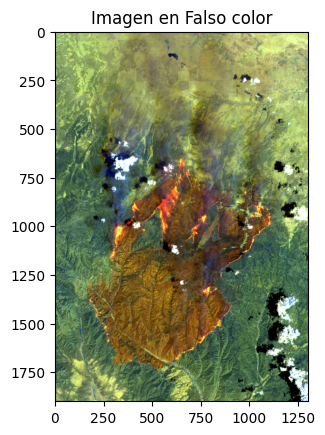

In [33]:
# Leemos las tres bandas 7, 5 y 4
banda7 = cv2.imread("/content/drive/MyDrive/Lansat/arizona/banda7.tif", cv2.IMREAD_GRAYSCALE)
banda5 = cv2.imread("/content/drive/MyDrive/Lansat/arizona/banda5.tif", cv2.IMREAD_GRAYSCALE)
banda4 = cv2.imread("/content/drive/MyDrive/Lansat/arizona/banda4.tif", cv2.IMREAD_GRAYSCALE)

# Combinamos las tres bandas
imagen_en_falso_color = np.zeros((banda7.shape[0], banda7.shape[1], 3), dtype=np.uint8)

# Asigno cada banda al canal RGB correspondiente
imagen_en_falso_color[:, :, 0] = banda7
imagen_en_falso_color[:, :, 1] = banda5
imagen_en_falso_color[:, :, 2] = banda4

# Visualizacion de la imagen en falso color
plt.imshow(imagen_en_falso_color)
plt.title('Imagen en Falso color')
plt.axis('on')
plt.show()

### 1.2 Calculo de la estimación del área de la zona quemada (en km2)

In [34]:
# Función para el calculo de ndvi
def calcular_ndvi(banda_nir, banda_rojo):
    # Convertimos las bandas a tipo float
    float_nir = banda_nir.astype(float)
    float_rojo = banda_rojo.astype(float)

    # Calculamos segun el índice de vegetación (NDVI)
    indice_ndvi = (float_nir - float_rojo) / (float_nir + float_rojo)

    return indice_ndvi

In [37]:
banda_nir = cv2.imread("/content/drive/MyDrive/Lansat/arizona/banda4.tif", cv2.IMREAD_GRAYSCALE)
banda_rojo = cv2.imread("/content/drive/MyDrive/Lansat/arizona/banda3.tif", cv2.IMREAD_GRAYSCALE)

# Asumiendo el tamaño de píxel en metros
pixel_size = 30

# Calculamos segun el índice de vegetación (NDVI)
ndvi = calcular_ndvi(banda_nir, banda_rojo)

#Implementamos una máscara para identificar las áreas quemadas
mascara_quemado = ndvi < 0

# Contamos los pixeles con ndvi < 0
p_quemados = np.count_nonzero(mascara_quemado)

# Calculo el área
area_quemada = p_quemados * (pixel_size ** 2) / 1000000

print("Estimación del área de la zona quemada:", area_quemada, "km²")

<ipython-input-34-4e254fb000e2>:8: RuntimeWarning: invalid value encountered in true_divide
  indice_ndvi = (float_nir - float_rojo) / (float_nir + float_rojo)


Estimación del área de la zona quemada: 1578.6882 km²


### 1.3 Implementación del algoritmo del documento

<ipython-input-42-6d59db7a2d09>:6: RuntimeWarning: invalid value encountered in true_divide
  nmdi = (banda_medio - banda_cercano) / (banda_medio + banda_cercano)


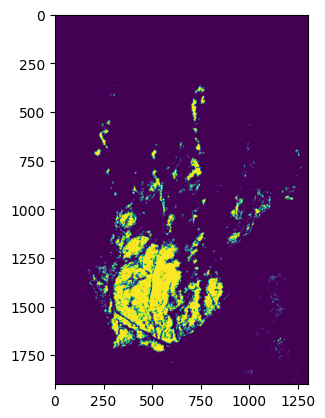

In [42]:
banda_roja = cv2.imread("/content/drive/MyDrive/Lansat/arizona/banda3.tif", cv2.IMREAD_GRAYSCALE).astype(float)
banda_cercano = cv2.imread("/content/drive/MyDrive/Lansat/arizona/banda4.tif", cv2.IMREAD_GRAYSCALE).astype(float)
banda_medio = cv2.imread("/content/drive/MyDrive/Lansat/arizona/banda5.tif", cv2.IMREAD_GRAYSCALE).astype(float)

# Calculamos el indice NMDI
nmdi = (banda_medio - banda_cercano) / (banda_medio + banda_cercano)

# Definimos el umbral para detectar incendios
Umbral = 0.5

# ubicaciones de los focos de incendio
focos_incendio = np.where(nmdi > Umbral)

# Imagen en blanco del mismo tamaño que las imágenes originales
incendio = np.zeros_like(banda_roja)

# Marcaos los focos de incendio en la imagen
incendio[focos_incendio] = 255

# Guardar la imagen resultante con los focos de incendio detectados
plt.imshow(incendio)
plt.axis('on')
plt.show()

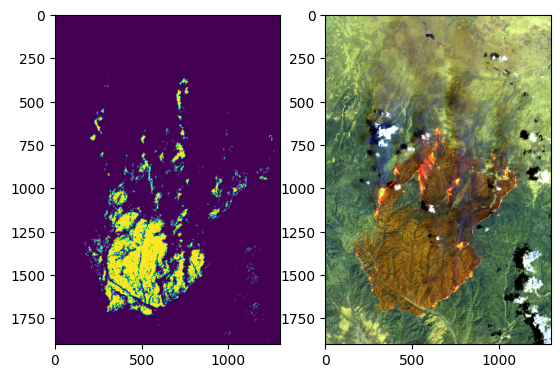

In [48]:
# Comparación de las imágenes
plt.subplot(1, 2, 2)
plt.imshow(imagen_en_falso_color)
plt.axis('on')

plt.subplot(1, 2, 1)
plt.imshow(incendio)
plt.axis('on')

plt.show()

En esta segunda parte del trabajo, se realiza un análisis de las imágenes satelites de Arizona para detectar incendios y estimar el área quemada en una zona específica. Se utilizan las bandas 7, 5 y 4 de una imagen Landsat de Arizona.

En primer lugar, se leen las tres bandas mencionadas y se combinan para crear una imagen en falso color. Cada banda se asigna al canal RGB correspondiente, lo que permite visualizar la imagen en colores.

A continuación, se define una función para calcular el Índice de Vegetación de Diferencia Normalizada (NDVI) utilizando las bandas de infrarrojo cercano (NIR) y rojo. El NDVI se calcula como la diferencia entre la banda NIR y la banda roja dividida por su suma. Este índice permite identificar la vegetación en las imágenes.

Se utilizan las bandas 4 y 3 para calcular el NDVI y se implementa una máscara para identificar las áreas quemadas, donde el valor del NDVI es menor que cero. Se cuenta el número de píxeles con NDVI menor que cero y se calcula el área quemada en kilómetros cuadrados, considerando el tamaño de píxel.

Se muestra la estimación del área de la zona quemada, que en este caso es de **1578.6882 km²**.

Luego, se implementa el algoritmo para detectar focos de incendio utilizando las bandas 3, 4 y 5. Se calcula el Índice de Diferencia Normalizada de Medio Infrarrojo (NMDI) como la diferencia entre la banda de infrarrojo medio y la banda de infrarrojo cercano dividida por su suma. Se establece un umbral de 0.5 para detectar los focos de incendio en la imagen.

Se crea una imagen en blanco del mismo tamaño que las imágenes originales y se marcan los focos de incendio en ella. La imagen resultante muestra los focos de incendio detectados.

Por último, se realiza una comparación visual entre la imagen en falso color y la imagen con los focos de incendio marcados.

# **Adra**

In [49]:
# Cargamos las imágenes
Pancromatica = cv2.imread("/content/drive/MyDrive/Lansat/adra/banda8.tif", cv2.IMREAD_GRAYSCALE)
r = cv2.imread("/content/drive/MyDrive/Lansat/adra/banda3.tif", cv2.IMREAD_GRAYSCALE)
g = cv2.imread("/content/drive/MyDrive/Lansat/adra/banda2.tif", cv2.IMREAD_GRAYSCALE)
b = cv2.imread("/content/drive/MyDrive/Lansat/adra/banda1.tif", cv2.IMREAD_GRAYSCALE)

Pancromatica = cv2.resize(Pancromatica, (r.shape[1], r.shape[0]))

## 1.1 Cambiar la luminancia por la imagen pancromatica en representación HSV

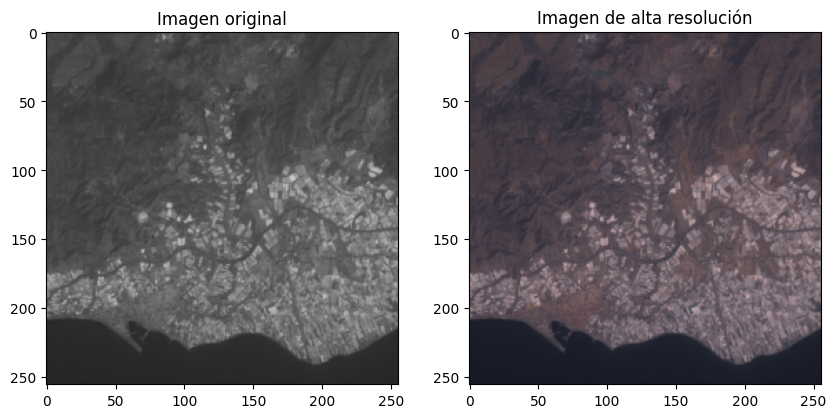

In [50]:
# Combinamos las bandas
rgb = np.empty((r.shape[0], r.shape[1], 3), dtype=np.uint8)
rgb[:, :, 0] = b
rgb[:, :, 1] = g
rgb[:, :, 2] = r

# Conversión a espacio de color HSV
hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)

# Cambiamos el canal de luminancia por la pancromática
hsv[..., 2] = Pancromatica

# Volvemos a la representación RGB
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
pancromatica_out = cv2.cvtColor(Pancromatica, cv2.COLOR_BGR2RGB)

# Visualización de la imagen resultante
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pancromatica_out)
plt.title('Imagen original')
plt.axis('on')
plt.subplot(1, 2, 2)
plt.imshow(rgb)
plt.title('Imagen de alta resolución')
plt.axis('on')

plt.show()

## 1.2 Usando la transformada wavelet de la imagen pancromatica

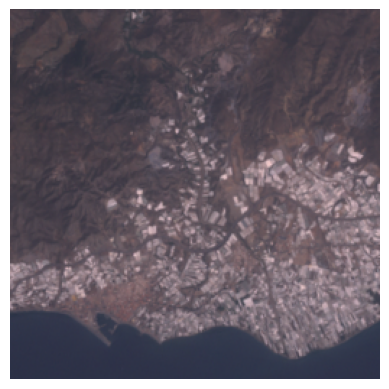

In [51]:
# Aplicamos la transformada wavelet a la imagen pancromática
wavelet = 'db4'
panchromatic_coeffs = pywt.wavedec2(Pancromatica, wavelet)

# Aplicar la transformada wavelet a las bandas RGB
rcoeffs = pywt.wavedec2(r, wavelet)
gcoeffs = pywt.wavedec2(g, wavelet)
bcoeffs = pywt.wavedec2(b, wavelet)

# Reconstruir las bandas RGB fusionadas
fusion_rband = pywt.waverec2(rcoeffs, wavelet)
fusion_gband = pywt.waverec2(gcoeffs, wavelet)
fusion_bband = pywt.waverec2(bcoeffs, wavelet)

# Crear una imagen RGB fusionada
fusion_image = np.zeros((Pancromatica.shape[0], Pancromatica.shape[1], 3), dtype=np.uint8)
fusion_image[:, :, 0] = fusion_bband.astype(np.uint8)
fusion_image[:, :, 1] = fusion_gband.astype(np.uint8)
fusion_image[:, :, 2] = fusion_rband.astype(np.uint8)

fused_image = cv2.cvtColor(fusion_image, cv2.COLOR_BGR2RGB)
plt.imshow(fused_image)
plt.axis('off')
plt.show()

## 1.3  Algoritmo propuesto

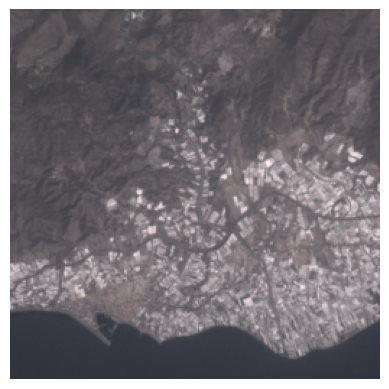

In [52]:
# Fusionamos las bandas mediante (PCA)
pca_image = cv2.merge((b, g, r))

# Convertimos la imagen pancromática a color
panc_color = cv2.cvtColor(Pancromatica, cv2.COLOR_GRAY2RGB)

# Mezclamos la imagen pancromática y la imagen fusionada
imagen_resultante = cv2.addWeighted(panc_color, 0.7, pca_image, 0.5, 0)

# Visualización de la imagen resultante
imagen_resultante = cv2.cvtColor(imagen_resultante, cv2.COLOR_BGR2RGB)
plt.imshow(imagen_resultante)
plt.axis('off')
plt.show()

En esta última parte del trabajo, se realiza un análisis de imágenes de Adra para mejorar la resolución y fusionar las bandas de una imagen de alta resolución utilizando diferentes técnicas.

En primer lugar, se cargan las imágenes correspondientes a la banda pancromática (banda 8), la banda roja (banda 3), la banda verde (banda 2) y la banda azul (banda 1) de una imagen Landsat de Adra.

Luego, se redimensiona la imagen pancromática para que tenga el mismo tamaño que las bandas RGB. A continuación, se combinan las bandas RGB en una imagen RGB y se convierte a espacio de color HSV.

Se reemplaza el canal de luminancia en la representación HSV por la imagen pancromática, lo que permite aumentar la resolución de la imagen. Luego, se vuelve a convertir la imagen a representación RGB y se muestra la imagen de alta resolución resultante junto con la imagen original.

A continuación, se aplica la transformada wavelet a la imagen pancromática y a las bandas RGB utilizando la función wavelet "db4". Se reconstruyen las bandas RGB fusionadas utilizando los coeficientes de la transformada wavelet y se crea una imagen RGB fusionada.

Se muestra la imagen fusionada resultante, donde se ha mejorado la resolución y se han fusionado las bandas mediante la transformada wavelet.

Por último, se propone un algoritmo de fusión de bandas mediante el método de Componentes Principales (PCA). Se fusionan las bandas mediante el PCA y se convierte la imagen pancromática a color. Luego, se mezcla la imagen pancromática y la imagen fusionada utilizando la función "addWeighted" de OpenCV.

Se muestra la imagen resultante, donde se ha fusionado las bandas utilizando el algoritmo propuesto.

# **Bibliografía**

1. Coutinho, R. M., Rodrigues, H. O., Pinto, F. A. C., et al. (2018). Assessing Vegetation Response to Drought in the Brazilian Amazon Using Normalized Difference Vegetation Index (NDVI). Remote Sensing.

2. Barooah, M., Gogoi, N., & Sarma, B. (2019). Assessment of Vegetation Dynamics and Their Relationship with Climate Parameters in a Semi-Arid Region Using Normalized Difference Vegetation Index (NDVI) Time Series. Journal of the Indian Society of Remote Sensing.

3. James Verdin, Diego Pedreros, Gary Eilerts (2003). "Índice Diferencial de Vegetación Normalizado (NDVI)", FEWS - Red de Alerta Temprana Contra la Inseguridad Alimentaria, Centroamérica, USGS/EROS Data Center, 2003.

4. Chen, X., Chen, Y., Han, G., et al. (2018). Assessing Vegetation Water Content using Normalized Difference Water Index (NDWI) in a Dryland Agriculture Region. Agricultural Water Management, 207, 129-139. doi: 10.1016/j.agwat.2018.05.015

5. Roy, D. P., Kovalskyy, V., Zhang, H. K., et al. (2016). Characterization of Landsat-7 to Landsat-8 reflective wavelength and normalized difference vegetation index continuity. Remote Sensing of Environment, 185, 57-70. doi: 10.1016/j.rse.2015.12.024